# Exploration 05_ STT        
---
## 이 노드의 루브릭      
1. 음성데이터를 2차원 Spectogram으로 변환하여 데이터셋을 구성하였다.      
    -> "스펙토그램 시각화 및 train/test 데이터셋 구성이 정상 진행되었다."    
    
    
2. 1, 2차원 데이터를 처리하는 음성인식 모델이 정상 작동한다.          
    -> "스펙토그램을 입력받은 모델이 학습 과정에서 안정적으로 수렴하며, evaluation/test 단계를 무리없이 진행 가능하다.      
    
    
    
3. 테스트셋 수행 결과 음성인식 모델의 Accuracy가 일정 수준에 도달하였다.     
    -> "평가 결과 75% 이상의 정확도를 달성하는 모델이 하나 이상 존재한다."    

---
### 목차       

1. 데이터 처리와 분류    
  - 라벨 데이터 처리하기
  - sklearn의 train_test_split 함수를 이용하여 train, test 분리   
2. 학습을 위한 하이퍼파라미터 설정     
3. 데이터셋 구성        
  - tf.data.Dataset을 이용       
  - from_tensor_slices에 return 받길 원하는 데이터를 튜플 형태로 받음   
  - map과 batch를 사용한 데이터 전처리.
  - 메모리 비우기 수행하기    
  
  > del speech_data
  > del spec_data
  
4. 2차원 Spectogram 데이터를 처리하는 모델 구성     
  - 2차원 Spectogram 데이터의 시간축 방향으로 Conv1D/Conv2D 레이어를 적용가능    
  - batchnorm, dropout, dense layer 를 이용    
  - 12개의 단어 class를 구분하는 loss를 사용하고, Adam optimizer 사용   
  - 모델 가중치를 저장하는 checkpoint callback 함수 추가     
  
5. 학습 내용 그래프 출력
  - loss, accuracy를 그래프로 표현     
  
6. Test dataset을 이용한 모델의 성능 평가   
  - 저장한 weight 불러오기    
  - 모델의 예측값과 정답값이 얼마나 맞는지 확인

### 1. 데이터 처리와 분류      
##### 데이터 가져오기       
* 기존에는 Waveform 데이터로 입력받아, Text라벨을 출력하는 모델을 만들었다.    
* 이제 이 데이터를 Spectogram으로 입력받아, 동일 역할을 수행하는 모델을 만든다.

In [2]:
import numpy as np
import os

data_path = os.getenv("HOME")+'/SUBMIT_MISSION_GIT/ex5_STT/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

print("데이터를 가져왔다!")
print("wav 상태 그대로의 데이터 셰이프 :", speech_data["wav_vals"].shape)

데이터를 가져왔다!
wav 상태 그대로의 데이터 셰이프 : (50620, 8000)


##### 내겐 너무 어려웠던 데이터 형변환         
* 사실, speech_data -> spectogram data로 형변환하는 과정이 너무 어려웠다.   
* 하나하나씩 차근히 분해해보기로 했다.         
---
1. 일단, speech_data를 이루고 있는 저 npz 확장자는 대체 무엇인지     
* npz 파일 포맷은 여러 개의 리스트를 한번에 저장하기 위한 포맷이다.     
* 그렇군.      
---
* 그럼, 얘 안에 들어있는 데이터들은 뭘까?      
* 위에서 speech_data를 살펴보았을 때, 데이터는     
* speech_data["wav_vals"]와 speech_data["label_vals"]가 있었다.    
* wav_vals는 음성 데이터, label_vals는 음성의 뜻을 의미하는 라벨 데이터이다.  
* 프린트해서 다시 확인해보자.

In [3]:
#wav_vals와 label_vals 인쇄
print("음성 데이터 shape : " ,speech_data["wav_vals"].shape)
print("\n어떻게 생겼나?" , speech_data["wav_vals"][0])

print("\n라벨 데이터 shape : " ,speech_data["label_vals"].shape)
print("\n어떻게 생겼나?" , speech_data["label_vals"][0])

음성 데이터 shape :  (50620, 8000)

어떻게 생겼나? [-1.27418665e-04 -1.12644804e-04 -1.86756923e-04 ... -1.62762426e-05
 -4.93293861e-04 -3.55132594e-04]

라벨 데이터 shape :  (50620, 1)

어떻게 생겼나? ['down']


* 인쇄해봤더니, 위와 같았다.     
* 음성데이터는 (음성개수:50620개, 샘플링 레이트 8000)       
* 라벨데이터는 (라벨개수:50620개, 라벨 값이 들어간 1개)   
* 의 모양으로 생긴 것을 확인할 수 있다.       
---
__그럼 우리는 이제 spectogram 데이터가 어떤 모양인지 알아야 한다!__   

![데이터 변환](./PostingPic/data.png)         

* 사진을 보면, 노드에서 wav데이터를 spectogram으로 변환할 때     
* Waveform shape(8000,) 스펙토그램(130,126)으로 바뀐 것을 알 수 있다.    
* 그럼 일렬로 된 8000개의 샘플링 데이터를 -> 음성 1개당 (130,126)의 데이터로 변환시켜야 한다. 

In [4]:
#wav 데이터를 spectogram으로 변환한다.
import librosa

#wav 데이터를 spectogram 데이터로 바꾸는 매직
#fft_size는 스펙토그램 사이즈를 맞추기 위해 258로 고정   
def wav2spec(wav, fft_size=258):
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D

#변환한 data를 담아줄 리스트
specData =[]

for wav_data in speech_data["wav_vals"]:
    specData.append(wav2spec(wav_data))
    
print(specData[0])

[[8.0723902e-03 5.2032182e-03 3.4693219e-03 ... 1.8922662e-02
  3.3809434e-04 1.0142580e-02]
 [6.5486785e-03 3.2852096e-03 2.2495915e-03 ... 2.5527487e-02
  1.6525777e-02 3.2326202e-03]
 [2.4226354e-03 3.5080472e-03 2.4726372e-03 ... 2.7952474e-02
  2.6693283e-02 1.7628349e-02]
 ...
 [5.8292970e-04 2.9035914e-04 1.4131786e-05 ... 6.0245253e-05
  3.1307511e-04 5.0933618e-04]
 [5.2434229e-04 2.5860392e-04 1.2995474e-05 ... 2.1275569e-05
  2.2292971e-04 4.7651122e-04]
 [5.1448052e-04 2.5908535e-04 1.6500426e-06 ... 5.2643327e-06
  2.3299157e-04 4.3895244e-04]]


* 리스트로 만들었으니, 이 리스트의 형태를 연산할 수 있게 np.array로 변환해야 한다.

In [5]:
specData = np.array(specData)

print("Spectrogram shape : ",specData.shape)
print("1개 데이터의 모양 : ", specData[0].shape)

Spectrogram shape :  (50620, 130, 126)
1개 데이터의 모양 :  (130, 126)


* 50620개의 데이터를 1데이터 당 (130,126) 사이즈로 변환했다!

### 1. 데이터 처리하기 - 1) 라벨 데이터 처리하기          

* 그럼 이제 라벨 데이터도 같은 모양을 갖도록 처리해보자!     
* 현재의 라벨 데이터 모양을 출력해본다.       

In [6]:
print(speech_data["label_vals"].shape)

(50620, 1)


* 라벨 데이터의 종류들을 확인해보자.

In [7]:
label_list = np.unique(speech_data["label_vals"])
print(label_list)

['down' 'go' 'left' 'no' 'off' 'on' 'right' 'silence' 'stop' 'unknown'
 'up' 'yes']


* 이 12개의 데이터들을, 학습에 사용하기 위해 딕셔너리 형태로 바꿔준다.    
* 단, 현재 0:down, 1:go.... 로 되어있는 리스트를 거꾸로 down:0 이 되도록 바꿔주어야 컴퓨터가 처리 가능하다.   

In [8]:
label_data_dict = dict() 

for i, l in enumerate(label_list):
    label_data_dict[l] = i
    
label_list = label_data_dict

print("indexed labels : " , label_data_dict)

indexed labels :  {'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'silence': 7, 'stop': 8, 'unknown': 9, 'up': 10, 'yes': 11}


* 12개의 라벨이 모두 __라벨(str값):인덱스  의 형태로 변환__ 된 것을 확인할 수 있다.     
* 여기서 다시 라벨을 연산이 가능한 np.array 형태로 바꿔준다.

In [9]:
temp = []

for value in speech_data["label_vals"]:
    temp.append(label_list[value[0]])

print("전부 다 변환됐는가? : " , len(temp))
label_data = np.array(temp)

print(label_data.shape)
print("몇 개만 출력해보자 " ,  label_data[9] , label_data[2850])

전부 다 변환됐는가? :  50620
(50620,)
몇 개만 출력해보자  0 1


* 확인해보니, 50620개의 데이터가 모두 label_data 형태로 변환되었음을 알 수 있다. 

### 1.데이터 처리하기 - 2. 학습 데이터, 테스트 데이터 분리

In [10]:
from sklearn.model_selection import train_test_split

#차원 알려주기
sp_s=130
sp_p=126

# 학습데이터:테스트데이터 = 9:1 로 해 보았다 ㅎㅎ
train_spec, test_spec, train_label, test_label = train_test_split(specData, label_data, test_size=0.1, shuffle=True)
print("학습 데이터 수", len(train_spec))

train_spec = train_spec.reshape([-1, sp_s, sp_p,1])
test_spec = test_spec.reshape([-1, sp_s, sp_p,1])

#나눠진 데이터 모습을 확인해보자.
print("train_spec : ", train_spec.shape)
print("train_label :" , train_label.shape)
print("test_spec : ", test_spec.shape)
print("test_label :", test_label.shape)

학습 데이터 수 45558
train_spec :  (45558, 130, 126, 1)
train_label : (45558,)
test_spec :  (5062, 130, 126, 1)
test_label : (5062,)


### 2. 학습을 위한 하이퍼파라미터 설정          

* 혹시 모르는 마음에, 기본적인 설정은 노드와 동일하게 진행해주었다.      
* 추후 성능에 따라 하이퍼파라미터를 조정해주도록 한다.    

In [11]:
batch_size = 32
max_epoch = 10

#중간중간 저장해줄 체크포인트 생성
check_path = os.getenv('HOME')+'/SUBMIT_MISSION_GIT/ex5_STT/model/wav'

check_path

'/home/ssac23/SUBMIT_MISSION_GIT/ex5_STT/model/wav'

### 3. 데이터셋 구성 - 1) 데이터셋 구성     

---
__요건__       
* tf.data.Dataset을 이용        
* from_tensor_slices에 return 받길 원하는 데이터를 튜플 형태로 받음     
* map과 batch를 사용한 데이터 전처리

In [12]:
#정답 라벨 말고는 다 죽이는 one_hot_label
def one_hot_label(spec,label):
    
    #depth=12는 최종 결과값이 12개 나온다는 의미(물론 뒤에 1차원이 더 붙는다.)
    #우리 라벨 데이터는 12개이므로 depth=12임!
    label = tf.one_hot(label, depth=12)
    return spec, label

print("one_hot_label")

one_hot_label


In [13]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((train_spec, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

test_dataset = tf.data.Dataset.from_tensor_slices((test_spec, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)

print("데이터 처리 완료")

<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>
데이터 처리 완료


__메모리 비우기 수행하기__

In [14]:
del speech_data
del specData
print("비우기 완료!")

비우기 완료!


### 4. 2차원 Spectogram 데이터를 처리하는 모델 구성      
---   
__요건__     
* 2차원 spectogram 데이터의 시간축 방향으로 Conv1D 혹은 Conv2D 레이어를 적용 가능   
* batchnorm, dropout, dense layer를 이용    
* 12개의 단어 class를 구분하는 loss를 사용하고, Adam optimizer 사용     
* 모델 가중치를 저장하는 checkpoint callback 함수 추가

* __Conv2D 레이어__ 를 적용해보기로 했다.

In [18]:
from tensorflow.keras import layers

#spec_data의 형태를 알려준다.
input_tensor = layers.Input(shape=(sp_s, sp_p, 1))

x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_spec = tf.keras.Model(input_tensor, output_tensor)

model_spec.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 130, 126, 1)]     0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 130, 126, 32)      320       
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 130, 126, 32)      9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 65, 63, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 65, 63, 64)        18496     
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 65, 63, 64)        36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 32, 31, 64)        0   

* 진행하면서 conv1D -> conv2D로 바꿀 때 뭐가 필요할까? 라고 찾아보던 와중에     
* 커널 사이즈가 궁금해서 검색했더니 이런 답이 있었다.     

[커널 사이즈란 이런 것이다](https://stats.stackexchange.com/questions/296679/what-does-kernel-size-mean)     

* 인상적이어서 적어둠... 그리고 원래 소스코드에서는 커널이 9였는데,   
* 위의 글에서는 1, 2, or 3같은 넘버로 해라.. 적혀있어서 일단 3으로 바꿔보았다.(개중에 제일 큰것같아서..)   

### 4. 모델 구성 - 2) 손실함수 구성       
---
__요건__    
* 12개의 단어 클래스를 구분하는 loss를 사용하고, Adam optimizer 사용  

In [19]:
optimizer=tf.keras.optimizers.Adam(1e-4)

#multi-class classification에 사용된다는 CategorialCrossentropy
#여담이지만 docs에 Categorical_Crossentropy도 있었다.
#CategoricalCrossentropy -> computes the crossentropy loss between the labels and predictions
model_spec.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

print("손실함수 구성 완료")

손실함수 구성 완료


### 4. 모델 구성 - 3) 모델 가중치를 저장하기 위한 콜백함수 추가

In [21]:
spec_callback = tf.keras.callbacks.ModelCheckpoint(check_path,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

print("가중치 저장을 위한 콜백함수 설정 완료")

가중치 저장을 위한 콜백함수 설정 완료


### 4. 이제 드디어, 모델 학습...! 

In [24]:
#batch=32, epoch=10
history_spec = model_spec.fit(train_dataset, epochs=10,
                    steps_per_epoch=len(train_spec) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_spec) // batch_size,
                    callbacks=[spec_callback]
                    )

print("모델 학습")

Epoch 1/10
1423/1423 [==============================] - ETA: 0s - loss: 0.7550 - accuracy: 0.7571
Epoch 00001: val_loss improved from inf to 0.43234, saving model to /home/ssac23/SUBMIT_MISSION_GIT/ex5_STT/model/wav
1423/1423 [==============================] - 61s 43ms/step - loss: 0.7550 - accuracy: 0.7571 - val_loss: 0.4323 - val_accuracy: 0.8663
Epoch 2/10
1423/1423 [==============================] - ETA: 0s - loss: 0.2612 - accuracy: 0.9210
Epoch 00002: val_loss improved from 0.43234 to 0.24977, saving model to /home/ssac23/SUBMIT_MISSION_GIT/ex5_STT/model/wav
1423/1423 [==============================] - 61s 43ms/step - loss: 0.2612 - accuracy: 0.9210 - val_loss: 0.2498 - val_accuracy: 0.9233
Epoch 3/10
1423/1423 [==============================] - ETA: 0s - loss: 0.1643 - accuracy: 0.9513
Epoch 00003: val_loss improved from 0.24977 to 0.18675, saving model to /home/ssac23/SUBMIT_MISSION_GIT/ex5_STT/model/wav
1423/1423 [==============================] - 61s 43ms/step - loss: 0.1643 

* 학습이 무사히 끝났고, 학습 결과를 시각화 해 보도록 하겠다.     

### 5. 학습 내용 그래프로 출력      

* loss, accuracy를 그래프로 표현

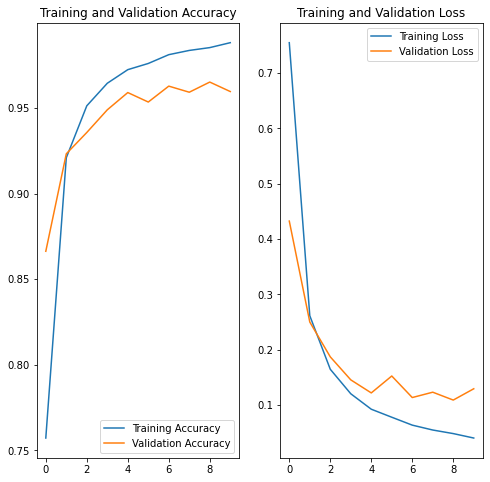

In [25]:
import matplotlib.pyplot as plt

#정확도와 손실율을 각 변수에 배정
acc = history_spec.history['accuracy']
val_acc = history_spec.history['val_accuracy']

loss=history_spec.history['loss']
val_loss=history_spec.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

* train loss와 validation loss가 크게 벌어지면 오버피팅 가능성이 있다.      
* epoch=4 이후로 격차가 크게 벌어졌다.

### 6. Test Dataset을 이용한 모델의 성능 평가 - 1) 저장한 weight 불러오기 

In [26]:
#우리가 콜백 함수를 통해 저장한 weight를 가져와보도록 하자.

model_spec.load_weights(check_path)

print("이전 기록을 가져왔다.")

이전 기록을 가져왔다.


### 6. Test Dataset을 이용한 모델의 성능 평가 2) 모델 평가하기

In [27]:
results = model_spec.evaluate(test_dataset)
print("테스트 데이터셋으로 평가해보자.")

#로스
print("\nloss value : {:.3f}".format(results[0]))

#정확도
print("\nacuuracy value : {:.4f}".format(results[1]*100))

159/159 [==============================] - 33s 205ms/step - loss: 0.1085 - accuracy: 0.9652
테스트 데이터셋으로 평가해보자.

loss value : 0.108

acuuracy value : 96.5231


* 정확도가 96.5로 나왔다.

### 번외. Skip-connection 모델을 적용하여 정확도를 개선해보자!

In [42]:
#skip-connection은  기존의 인풋값을 기억하여 변동된 값만을 추가학습하도록 하는 방법 
#y=f(x)+x
input_tensor = layers.Input(shape=(sp_s, sp_p, 1))

x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
skip_1 = layers.MaxPool2D()(x)

x = layers.Conv2D(64, 3, padding='same', activation='relu')(skip_1)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool2D()(x)

x = layers.Conv2D(128, 3, padding='same', activation='relu')(skip_2)
x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool2D()(x)

x = layers.Conv2D(256, 3, padding='same', activation='relu')(skip_3)
x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_spec_skip2 = tf.keras.Model(input_tensor, output_tensor)

model_spec_skip2.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 130, 126, 1) 0                                            
__________________________________________________________________________________________________
conv2d_47 (Conv2D)              (None, 130, 126, 32) 320         input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_48 (Conv2D)              (None, 130, 126, 32) 9248        conv2d_47[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_18 (MaxPooling2D) (None, 65, 63, 32)   0           conv2d_48[0][0]                  
____________________________________________________________________________________________

In [47]:
optimizer=tf.keras.optimizers.Adam(1e-4)

#multi-class classification에 사용된다는 CategorialCrossentropy
#여담이지만 docs에 Categorical_Crossentropy도 있었다.
#CategoricalCrossentropy -> computes the crossentropy loss between the labels and predictions
model_spec_skip2.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

print("손실함수 구성 완료")

손실함수 구성 완료


In [48]:
#이전의 모델과 분리
check_skip_path = os.getenv('HOME')+'/SUBMIT_MISSION_GIT/ex5_STT/skipPath/skip'

check_skip_path

spec_skip_callback = tf.keras.callbacks.ModelCheckpoint(check_skip_path,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

print("가중치 저장을 위한 콜백함수 설정 완료")

가중치 저장을 위한 콜백함수 설정 완료


__아까 학습이 epoch=4 인 이후로 train loss와 validation loss가 떨어졌으므로  epoch를 5로 정해준다.__ 

In [49]:
#batch=32, epoch=5
history_spec_skip2 = model_spec_skip2.fit(train_dataset, epochs=5,
                    steps_per_epoch=len(train_spec) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_spec) // batch_size,
                    callbacks=[spec_skip_callback]
                    )

print("모델 학습")

Epoch 1/5
1423/1423 [==============================] - ETA: 0s - loss: 0.8230 - accuracy: 0.7366
Epoch 00001: val_loss improved from inf to 0.36091, saving model to /home/ssac23/SUBMIT_MISSION_GIT/ex5_STT/skipPath/skip
1423/1423 [==============================] - 73s 51ms/step - loss: 0.8230 - accuracy: 0.7366 - val_loss: 0.3609 - val_accuracy: 0.8890
Epoch 2/5
1423/1423 [==============================] - ETA: 0s - loss: 0.2714 - accuracy: 0.9168
Epoch 00002: val_loss improved from 0.36091 to 0.26613, saving model to /home/ssac23/SUBMIT_MISSION_GIT/ex5_STT/skipPath/skip
1423/1423 [==============================] - 74s 52ms/step - loss: 0.2714 - accuracy: 0.9168 - val_loss: 0.2661 - val_accuracy: 0.9134
Epoch 3/5
1423/1423 [==============================] - ETA: 0s - loss: 0.1745 - accuracy: 0.9479
Epoch 00003: val_loss improved from 0.26613 to 0.17612, saving model to /home/ssac23/SUBMIT_MISSION_GIT/ex5_STT/skipPath/skip
1423/1423 [==============================] - 74s 52ms/step - loss

In [50]:
#우리가 콜백 함수를 통해 저장한 weight를 가져와보도록 하자.
model_spec_skip2.load_weights(check_skip_path)

print("이전 기록을 가져왔다.")

이전 기록을 가져왔다.


In [51]:
results = model_spec_skip2.evaluate(test_dataset)
print("테스트 데이터셋으로 평가해보자.")

#로스
print("\nloss value : {:.3f}".format(results[0]))

#정확도
print("\nacuuracy value : {:.4f}".format(results[1]*100))

159/159 [==============================] - 3s 17ms/step - loss: 0.1387 - accuracy: 0.9552
테스트 데이터셋으로 평가해보자.

loss value : 0.139

acuuracy value : 95.5156


## 좋은 결과였지만, 이전보다 좋은 정확도를 끌어내지는 못했다.

* ~한편으로는 너무 높은 정확도라서 과연 맞는 테스트였던걸까? 하는 생각이 들기도 한다.~     
* 어떻게 개선해야 더 좋은 결과를 이끌어낼 수 있을까?      
---
__시도해 볼 만한 것들__       
1. 정확도 평가를 바꿔보기 위해 다른 평가 set 써보고, 결과가 비슷하게 나오는지 보기
2. 만약 1에서 정확도 평가가 비슷하거나 더 낫게 나왔다면, 모델을 좀 바꿔보기(더 간소한 레이어로)    